# Investigating New York State Food Service Establishment Inspections Data

### Import data and rename columns for convenience:

In [12]:
import pandas as pd
parser = lambda x: pd.to_datetime(x, format='%m/%d/%Y', errors = 'coerce')
inspections = pd.read_csv(
    'Food_Service_Establishment_Inspections__Beginning_2005__ACTIVE_.csv',     # retrieved from data.gov (May 28, 2016), but
    parse_dates=[2, 18], date_parser=parser                                    # also available at health.data.ny.gov
)
inspections.columns = ['facility',              # name of business
                       'address',               # full address
                       'date',                  # date of inspection
                       'item',                  # code number for each violation ('None' if no violation)
                       'description',           # standardized textual description of each violation (missing if no violation)
                       'critical',              # is there a critical violaton?
                       'criticals',             # number of critical violations
                       'uncorrected',           # number of uncorrected critical violations
                       'noncriticals',          # number of non-critical violations
                       'health_dept',
                       'county',
                       'facility_code',
                       'facility_address',      # street address
                       'facility_city',         # city
                       'facility_zip',          # ZIP code
                       'nysdoh_code',           
                       'facility_municipality',
                       'operation_name',
                       'permit_expiration',
                       'service_type',
                       'service_description',
                       'dba',
                       'permitted_name',        # usually identical to 'facility'
                       'lastname',
                       'firstname',
                       'health_id',
                       'inspection_type',       # inspection or re-inspection
                       'comments',              # free-form (non-standardized) textual comments
                       'state',                 # always 'NY'
                       'latitude',              # location information
                       'longitude'              # location information
                      ]

### Minor cleaning:

In [13]:
inspections.loc[:,'critical'] = -(inspections.critical.str.startswith('Not'))   # Convert "critical" to a boolean
inspections['weekday'] = inspections.date.dt.dayofweek     # Track the day of the week (inspections seem to be rare on weekends)
inspections = inspections.drop('state', 1)                 # The state is always New York, so drop it

### Building a mapping from 'item' to 'description':

In [14]:
table = inspections.groupby(['item','description']).count()[['facility']].reset_index('description')
table

,description,facility
item,,
10,Inadequate refrigeration or heated food storag...,1
10A,Food (ice) contact surfaces are improperly des...,21819
10B,Non-food contact surfaces and equipment are im...,50466
11,"Thermometers inaccurate, improperly used, impr...",5
11A,"Manual facilities inadequate, technique incorr...",17813
11B,"Wiping cloths dirty, not stored properly in sa...",22857
11C,"Food contact surfaces not washed, rinsed and s...",29145
11D,Non food contact surfaces of equipment not clean,57902
12,"Personnel with unclean hands or clothing, toba...",2


### Note the issue with item 14 above. Looking for other problems with the mapping:

In [15]:
tableproblems = table[table.groupby(level = 0).count() > 1]
tableproblems[tableproblems.description.notnull()]

,description,facility
item,,
14,Food workers with inadequate personal cleanlin...,1.0
14,"Valid permit to operate, conspicuously posted ...",3.0
18,"Equipment not in good repair or maintained, no...",4.0
18,Pool Safety Plan Developed/Implemented/Updated...,1.0


### For unknown reasons, two inspections (out of almost 1 million) have anomalous item / description pairs:

In [16]:
inspections[
    (inspections.description.fillna('').str.startswith('Food workers with inadequate personal')) |
    (inspections.description.fillna('').str.startswith('Pool'))
]

,facility,address,date,item,description,critical,criticals,uncorrected,noncriticals,health_dept,...,dba,permitted_name,lastname,firstname,health_id,inspection_type,comments,latitude,longitude,weekday
609737,COURTYARD BY MARRIOTT FISHKILL,"17 WESTAGE DRIVE, FISHKILL",2015-06-22,18,Pool Safety Plan Developed/Implemented/Updated...,False,0.0,0.0,1.0,Dutchess County,...,NaN,NaN,NaN,NaN,276990,Inspection,NaN,41.526558,-73.894216,0
750426,NEW YORKER,"123 S Nanticoke AVENUE, ENDICOTT",2006-08-04,14,Food workers with inadequate personal cleanlin...,False,0.0,0.0,1.0,Broome County,...,NaN,"TERB, INC.","LAKOMEC, JR.",JOHN,256622,Inspection,NaN,42.095623,-76.065272,4


### Item / description pairs that overtly involve rodents:

In [17]:
table[table.description.str.contains('odent')]

,description,facility
item,,
14A,"Insects, rodents present",17592
14B,Effective measures not used to control entranc...,14698
27,Insects and rodents not controlled [14-4.160],1
62,"Insect, Rodent, Bat and Weed Control {7-2.21,...",1


### Inspections for which the comments (rather than the description) mention rodents:

In [18]:
pd.set_option('display.max_colwidth',99999)
pd.set_option('display.width', 200)
inspections[
    (inspections.comments.fillna('').str.contains('odent')) &
    -(inspections.description.fillna('').str.contains('odent'))
][['comments']]

,comments
108,**re-inspection to occurin or about 4 weeks. Summons to be issued to shellfish tags and rodents upon re-inspection
121,**re-inspection to occurin or about 4 weeks. Summons to be issued to shellfish tags and rodents upon re-inspection
5224,"5c.\nAt 11:10am these inspectors found approximately 2 lbs of cooked pasta in a plastic bin on the bottom of a cart at the end of the line. Using this inspectors calibrated food testing thermometer, it was found that the pasta was at 62deg F. We spoke to the chef sho stated that she was unaware of the bin of pasta on the bottom of the cart. She stated that the cart was removed from the cooler one hour ago. Allowed to put back in cooler and CORRECTED.\n\n10b.\nBlack microwave on hot line, interior is rusting and is not smooth and easily cleanable.\n\n8a.\nBoxes and containers of various food found stored directly on floor of walk-in cooler and freezer. Aslo, carrots and cabbage stored on floor in old walk-in cooler in basement.\n\n10b.\nBare wood pallets in basement storing food and single service items are not smooth and easily cleanable. (Repeat from 10/12/2011 and 11/14/2011)\n\n15a.\nWall leading down to basement (drywall) not smooth and easily cleanable and plywood ceiling is bare wood and also not smooth and easily cleanable. (Repeat from 10/12/2011 and 11/14/2011)\n\n14b.\nWindow by dishmachine is open without screen. May lead to entrance of insects and rodents.\n\n2e.\nAt 12:00pm these inspectors found the chefs food testing thermometer to be at 58deg F in an icebath. Inspectors thermometer read 32 deg F. Chefs food testing thermometer recalibrated by inspector and Corrected.\n\n15b.\nLights are not shielded in basement - fluorescent bulbs are there and are not shatter-proof"
5390,"5A--10 half pint cartons of 1% milk measured between 51 degrees and 53 degrees using the inspector's calbirated food testing thermomter. This product was in the cooler unit that measured at 53 degrees ambiant air temperature using the same thermometer. Kitchen staff voluntarily discarded these 10 cartons. Corrected\n8A--Food stored on floor in walk-in cooler, walk-in freezer, & dry storage area. Food found stored on a pop crate in the walk-in freezer & on full pallets which neither is >=6 inches off of the floor or easily movable racks to allow for easy access for cleaning. Food also in the walk-in cooler is found uncovered.\n8C--Clean, sanitized utensils found on cloth towel on prep table in kitchen, not a food grade surface. \n10B--Bare wood surfaces found in refrigeration units and storage areas, not smooth and easily cleanable. \n11C--Kitchen staff using a soap and bleach solution to clean tables in between uses, surfaces must be washed, rinsed, and sanitized in between uses. Corrected. \n12C--Sanitizing sink in 3 bay sink area and hand wash sink by service line & hot hold unit are leaking underneath. Vegetable sink drain does not have an air gap. \n14C--Found rodent glue strips in dry storage area, not enclosed type traps. \n15B--Dust accumulation found in ventilation hood above cook line. Light shield missing in mop sink area and a shield is broken on light in hallway between dry storage and walk-in freezer. \n"
6284,"1H Pies on cooling rack not protected from numerous flies.moved behind screen.\n2C Cabbage in baskets, zuccinni and grapes on shelf above prepared raw vegatables in walkin above clean and sliced carrots, broccoli, cauliflower, yellow squash and zuccinni in bowls. moved. to higher shelf ok\n2D 2 large martini or brandy sniffers 2/3 full of pesto and hummus, covered and on shelf by fresh dips in plastic. Appeared to be held for reservice at todays wedding. Discarded. ok\n5B Sauce in heavy crockpot in walkin cooler with lid tightly closed and still in electrical unit. not transferred to acceptable container to cool or at proper depth. Soups, brussel sprouts, stew also. \ndiscarded ok\n8A Bags of ice on floor in walk in freezer\n10B Wood shelving is not easily cleanable in cate

### A crude geographical map of a sample of the data, with rodent-related inspections marked in red:

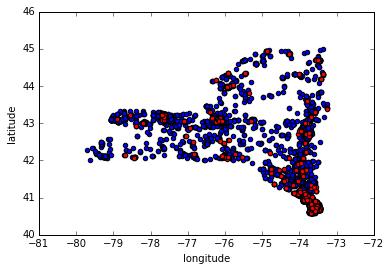

In [19]:
%matplotlib inline
sample = inspections[inspections.item != 'None'].sample(5000)
ratindex = (sample.item == '14A') | (sample.description.fillna('').str.contains('odent'))
ax = sample[
    (sample.latitude != 0) & -ratindex
].plot(x='longitude', y='latitude', kind='scatter')

sample[
    (sample.latitude != 0) & ratindex
].plot(x='longitude', y='latitude', kind='scatter', color='red', ax=ax)

### *Upon seeing the map, I "read the fine print" and realized that this data set explicitly excludes New York City ... Oops!*